# Building Permit Metrics of San Francisco

## Packages & Raw Data Import

In [36]:
import geopandas as gpd
import pandas as pd
import numpy as np

import os 
os.chdir(r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics')

mile2feet = 5280
mi2ft = mile2feet 
feet2mile = 1/mile2feet
ft2mi = feet2mile

In [37]:
DATA_FOLDER = r'data'
META_FOLDER = DATA_FOLDER + r'\meta'
RAW_FOLDER = DATA_FOLDER + r'\raw'
CLEAN_FOLDER = DATA_FOLDER + r'\clean'

Import in San Francisco Neighborhoods and Quadrants

In [38]:
project_crs = 'EPSG:7132'
path = RAW_FOLDER + r'\georeference\sf_neighborhoods.geojson'
sfnhood = gpd.read_file(path).to_crs(project_crs)
project_crs = sfnhood.crs

path = RAW_FOLDER + r'\georeference\sf_quadrants.geojson'
sfquad = gpd.read_file(path).to_crs(project_crs)

path = CLEAN_FOLDER + r'\sf_2010censusblock.geojson'
sfblock = gpd.read_file(path).to_crs(project_crs)

sftract = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)
non_res_geoid10 = [
    '06075060100', #presidio
    '06075980300', # golden gate park
    '06075980200', # land's end
    '06075060400', # Mercer Park
    '06075980501' # McLaren
]
sftract_res = sftract[~sftract['geoid10'].isin(non_res_geoid10)]

sf_landform = sfblock.unary_union
sf_landform = gpd.GeoDataFrame(geometry=[sf_landform], crs=project_crs)
sf_landform_res = sftract_res.unary_union
sf_landform_res = gpd.GeoDataFrame(geometry=[sf_landform_res], crs=project_crs)
sf_landform_nonres = gpd.overlay(sf_landform, sf_landform_res, how='symmetric_difference')

def geoid10_edit(n):
    g = str(n).zfill(11)
    return g

C:\Users\nelms\AppData\Local\Temp\ipykernel_25464\1171670404.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sftract = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)


### Import San Francisco Planning Permits 2016-2022
Pre-Cleaned Accela Permits from SF Open Data Portal ([pre-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-before-January-1-2013/)
 or [post-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-on-or-after-January-1-2013/))

Column Metadata to rename columns & determine which ones to keep

In [39]:
#path = META_FOLDER + r'\sf_planning_permit_fields.xlsx'
#sfp_meta = pd.read_excel(path)

#new_col_names = {
#    old.lower():new for old,new in sfp_meta[['Column Name','New Name']].values 
#    if type(new) == str
#}
#keep_cols = sfp_meta.loc[sfp_meta['Keep']=='y', 'Column Name'].str.lower().to_list() + ['geometry']

Import in geojson of geolocated & cleaned permits

In [40]:
#import pandas as pd
#import geopandas as gpd

#path = RAW_FOLDER + r'\sf_planning_permits_20220321.geojson'
#sfp_full = gpd.read_file(path)

KeyboardInterrupt: 

Prepare Dataset:
1. Filter by 'Project Profile' permits *(which are the 'main' permit)* & columns
2. Rename columns with metadata
3. Set integer & date type columns
4. Filter by permits with some form of proposed units
5. Remove Empty Geometry
6. Filter permits by:
    * A Start Date of Mid-2014
    * A Close Date of Mid-2015
7. Join to Neighborhoods

# 1. FILTER BY PERMIT TYPE
prj_filt = sfp_full['record_type']=='PRJ'
sfp = sfp_full[prj_filt][keep_cols].copy()

# 2. RENAME COLUMNS
sfp.columns = [
    new_col_names[c] if c in new_col_names.keys()
    else c
    for c in list(sfp)
]

# 3. SET DATA TYPES
## INTEGERS
unit_col = [c for c in list(sfp) if '#' in c]
sfp[unit_col] = sfp[unit_col].astype(float).astype(int)
## DATES
date_col = [c for c in list(sfp) if 'date' in c]
sfp[date_col] = sfp[date_col].apply(pd.to_datetime)

# 4. FILTER BY UNITS
all_filt = sfp['#units_prop']>0
mr_filt = sfp['#units_prop_mr']>0
sfp = sfp[all_filt|mr_filt]

# 5. REMOVE EMPTY GEOMETRY
sfp = sfp[~sfp['geometry'].is_empty] 
sfp_all = sfp.copy()

# 6. SET DATES 
## OPEN DATE OF 2014
date_open = '2014Q3'
open_filt = sfp['date_open']>date_open
## CLOSE DATE OF MID-2015
date_close = '2015Q3'
close_filt = sfp['date_close'].dt.to_period("Q")>=date_close
sfp = sfp[open_filt&close_filt]

# 7. JOIN TO NEIGHBORHOODS
sfp = sfp.sjoin(sfnhood).drop(columns='index_right')

### Building Permits

In [ ]:
path = RAW_FOLDER + r'\sf_building_permits_20220411.csv'
sfb_full = pd.read_csv(path)

path = META_FOLDER + r'\sf_building_permit_fields.xlsx'
sfb_meta = pd.read_excel(path)
sfb_meta = sfb_meta.loc[sfb_meta['keep']=='y'].set_index('name')['new_name'].to_dict()

#for c in sfb_meta.keys(): 
#    if c not in list(sfb_full):
#        print(c)

sfb_full = sfb_full[sfb_meta.keys()].rename(columns=sfb_meta).sort_values('date_issued')
for c in [c for c in sfb_meta.values() if 'date' in c]:
    sfb_full[c] = pd.to_datetime(sfb_full[c])

wgs84_crs = "epsg:4326"

sfbg = sfb_full[['pid', 'rid', 'geometry']]
sfbg = gpd.GeoDataFrame(sfbg, geometry=gpd.GeoSeries.from_wkt(sfbg['geometry']), crs=wgs84_crs).to_crs(project_crs)
sfbg = gpd.overlay(sfbg, sftract, how='intersection')
sfbg.head()

sfb_full = sfb_full.set_index(['pid','rid']).join(sfbg[[c for c in list(sfbg) if c != 'geometry']].set_index(['pid','rid'])).reset_index(drop=False)

date_col = 'date_issued'
year_bins = ['2000', '2005', '2010', '2015', '2020'] 
year_bins = pd.to_datetime(year_bins)
year_labels = ['00-04', '05-09', '10-14', '15-19']
sfb_full['5years'] = pd.cut(sfb_full[date_col], year_bins, labels=year_labels, include_lowest=True)

sfb_full.head()

C:\ProgramData\Miniconda3\envs\permit_metrics\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,pid,rid,date_start,desc,status,units_prop,use_prop,date_status,geometry,date_issued,geoid10,5years
0,9908229S,836112162081,1999-04-28,erect a three story fourteen unit residential ...,complete,14,apartments,2003-05-14,POINT (-122.41241836934992 37.756039544888395),2001-01-02,06075022803,00-04
1,200002222441,805277386263,2000-02-22,erect 2 story single family dwelling,complete,1,1 family dwelling,2002-08-06,POINT (-122.46369767113859 37.74514388048755),2001-01-02,06075030400,00-04
2,200002222434,805157146486,2000-02-22,erect a new two story single family dwelling,complete,1,1 family dwelling,2002-08-06,POINT (-122.4636154847457 37.74520807711159),2001-01-02,06075030400,00-04
3,9908229S,836111162082,1999-04-28,erect a three story fourteen unit residential ...,complete,14,apartments,2003-05-14,POINT (-122.41253760625708 37.756031983169024),2001-01-02,06075022803,00-04
4,200003305890,80903197856,2000-03-30,"to erect 4 stories, 3 family dwelling",complete,3,apartments,2003-09-26,POINT (-122.48551931234834 37.78410694871072),2002-01-02,06075042700,00-04


In [ ]:
date_col = '5years'
sfbb = sfb_full.groupby(['geoid10', date_col]).agg({
    'units_prop':'sum', 'rid':'count'
    }).reset_index(drop=False)
sfbb = sfblock.set_index('geoid10').join(sfbb.set_index('geoid10')).rename(columns={
    'units_prop':'units.tot',
    'rid':'permits.tot'
})
sfbb_j = sfbb[[c for c in list(sfbb) if c not in ['block_id', 'geometry']]] \
    .reset_index() \
    .set_index(['geoid10', '5years']) \
    .dropna()

per_types = ['units.tot', 'permits.tot']
sfbb_jp = sfbb_j.reset_index(drop=False).pivot(
    index='geoid10',
    columns='5years',
    values=per_types
)
sfbb_jp.columns = [
    t + '.' + y.replace('-','_') for t,y in sfbb_jp.columns
    ]

keep_years = []
for search_yrs in [['00_04', '05_09', '10_14']]:
    evicts10_19 = [c for c in list(sfbb_jp) if any(yrs for yrs in search_yrs if yrs in c)]
    for start in range(0,len(evicts10_19), len(search_yrs)):
        cols = evicts10_19[start:start+len(search_yrs)]
        typ = cols[0].split('.')[0]
        focus_years = search_yrs[0][0:2] + '_' + search_yrs[-1][-2:]
        focus_cols = typ+'.tot.{}'.format(
            focus_years
        )
        sfbb_jp[focus_cols] = sfbb_jp[cols].sum(axis=1)
        keep_years.append(focus_cols)

miss_geos = list(sfbb_jp.index) + [i for i in sftract['geoid10'].unique() if i not in sfbb_jp.index]

sfbb_jp = sfbb_jp.reindex(miss_geos,fill_value=0)

### Eviction Data

In [ ]:
#path = RAW_FOLDER + r'\sf_holc1937_districts.geojson'
#sfholc = gpd.read_file(path).to_crs(project_crs)
#sfholc = sfholc[['holc_grade', 'geometry']]
#sfholc.plot(column='holc_grade')

# RENAME & META DF
path = META_FOLDER + r'\sf_evict_fields.xlsx'
sfevict_meta = pd.read_excel(path)
sfevict_rename = sfevict_meta[sfevict_meta['keep']=='y'].set_index('name')['new'].to_dict()
sfevict_counts = sfevict_meta[sfevict_meta['evict_num']=='y']
# GROUP COUNTS
sfevict_groups = sfevict_counts.groupby('evict_group').agg({'new':list})['new'].to_dict()
sfevict_counts = list(sfevict_counts['new'].unique())

# IMPORT & RENAME
path = RAW_FOLDER + r'\evict\sf_evict_20220413.csv'
sfevict = pd.read_csv(path)
sfevict = sfevict[sfevict_rename.keys()].rename(columns=sfevict_rename)
sfevict[sfevict_counts] = sfevict[sfevict_counts].replace(True, 1).replace(False,0)
# COUNT FIELDS
for grouper, group_list in sfevict_groups.items():
    sfevict[grouper] = sfevict[group_list].sum(axis=1)
sfevict['tot_evictions'] = 1
count_cols = list(sfevict_groups.keys()) + ['tot_evictions']
# GET GEOM PTS
sfevict = sfevict[sfevict['shape'].apply(type)==str]
sfevict['geometry'] = gpd.GeoSeries.from_wkt(sfevict['shape'])
sfevict = gpd.GeoDataFrame(sfevict, crs=wgs84_crs).to_crs(project_crs)
# FILTER
sfblock_filter = gpd.GeoDataFrame(geometry=sf_landform.buffer(.1 * mile2feet), crs=project_crs)
sfevict = gpd.overlay(
    sfevict,
    sfblock_filter,
    how='intersection'
    )
sfevict = gpd.sjoin_nearest(
    sfevict, sftract_res, how='inner', max_distance=1000 
)

# DATE
date_col = 'file_date'
sfevict[date_col] = pd.to_datetime(sfevict[date_col])
year_bins = ['2000', '2005', '2010', '2015', '2020'] 
year_bins = pd.to_datetime(year_bins)
year_labels = ['00-04', '05-09', '10-14', '15-19']
sfevict['5years'] = pd.cut(sfevict[date_col], year_bins, labels=year_labels, include_lowest=True)

# group_by
agg_cols = {c:sum for c in count_cols}
sfevict = sfevict.groupby(['geoid10', '5years']).agg(agg_cols)

In [ ]:
evict_types = ['breach_lease', 'change_use', 'reno', 'renter_payment', 'tot_evictions']
c = evict_types[0]
sfevict_p = sfevict.reset_index(drop=False).pivot(
    index='geoid10',
    columns='5years',
    values=evict_types
)
sfevict_p.columns = [
    t.replace('tot_','') + '.tot.' + y.replace('-','_') for t,y in sfevict_p.columns
    ]
keep_years = []
for search_yrs in [['10_14','15_19'], ['00_04', '05_09', '10_14','15_19']]:
    evicts10_19 = [c for c in list(sfevict_p) if any(yrs for yrs in search_yrs if yrs in c)]
    for start in range(0,len(evicts10_19), len(search_yrs)):
        cols = evicts10_19[start:start+len(search_yrs)]
        typ = cols[0].split('.')[0]
        focus_years = search_yrs[0][0:2] + '_' + search_yrs[-1][-2:]
        focus_cols = typ+'.tot.{}'.format(
            focus_years
        )
        if (focus_years == '00_19')and(typ!='evictions'):
            pass
        else:
            sfevict_p[focus_cols] = sfevict_p[cols].sum(axis=1)
            keep_years.append(focus_cols)
sfevict_p = sfevict_p[keep_years]

miss_geos = list(sfevict_p.index) + [i for i in sftract['geoid10'].unique() if i not in sfevict_p.index]

sfevict_p = sfevict_p.reindex(miss_geos,fill_value=0)

### Demographic Data

In [ ]:
path = RAW_FOLDER + r'\bayarea_demodata_censusblock.json'
sfdemo = gpd.read_file(path, crs=wgs84_crs).to_crs(project_crs)
# FILTER BY FIPS
sfdemo['geoid10'] = sfdemo['geo_fips'].apply(geoid10_edit)
sfdemo = sfdemo[sfdemo['geoid10'].str[0:5] == '06075']
# FILTER BY GEO
sfdemo = gpd.overlay(sfdemo, sf_landform, how='intersection')
# FORMAT COLUMNS
admin_col = ['_tract','fips','geo_fips','field_1', 'geoid10', 'geometry']
sfdemo[[c for c in list(sfdemo) if c not in admin_col]] = sfdemo[[c for c in list(sfdemo) if c not in admin_col]].astype(float)

sfdemo['geoid10'] = sfdemo['geo_fips'].apply(geoid10_edit)
sfdemo['poc_linc.pct.10_15'] = sfdemo['lw_poc']
#sfdemo['blk_linc.pct.10_15'] = sfdemo['lw_blk']
sfdemo['wht.pct.10_15'] = sfdemo['all_wht']
sfdemo.loc[sfdemo['poc_linc.pct.10_15']<-8000, 'poc_linc.pct.10_15'] = -1000
sfdemo.loc[sfdemo['wht.pct.10_15']<-8000, 'wht.pct.10_15'] = -1000
sfdemo = sfdemo.set_index('geoid10')[[c for c in list(sfdemo) if ('.10_15' in c) or c == 'geometry']]

# all    All
# asn    Asian
# blk    Black
# hsp    Latinx
# poc    All People of Color
# wht    White

# all    All
# h    High [>120% AMI]
# m    Middle [80%-120% AMI]
# lw    Low [<80% AMI]
# vl    Very Low [<50% AMI]
# el    Extremely Low [<30% AMI]

#path = RAW_FOLDER + r'\bayarea_rentdata_censusblock.json'
#sfrent = gpd.read_file(path, crs=wgs84_crs).to_crs(project_crs)

#sfrent = gpd.overlay(
#    sfrent,
#    sf_landform,
#    how='intersection'
#    )

### Displacement Metrics

In [108]:
path = META_FOLDER + r'\sf_displace_fields.xlsx'
sfdis_meta = pd.read_excel(path)
sfdis_rename = sfdis_meta[sfdis_meta['keep']=='y'].set_index('name')['new'].to_dict()
sfdis_rename['geometry'] = 'geometry'
#sfdis_counts = sfdis_meta[sfdis_meta['evict_num']=='y']
# GROUP COUNTS
#sfdis_groups = sfdis_counts.groupby('evict_group').agg({'new':list})['new'].to_dict()
#sfdis_counts = list(sfdis_counts['new'].unique())

In [109]:
path = RAW_FOLDER + r'\displacement-typologies\sf_displace_db_2018.csv'
sfdis = pd.read_csv(path)
sfdis = sfdis[list(sfdis_rename.keys())].rename(columns=sfdis_rename)
# FILTER BY CA & SF FIPS CODES 
sfdis['geoid10'] = sfdis['geoid10'].apply(geoid10_edit)
sfdis = sfdis[sfdis['geoid10'].str[0:5] == '06075']

float_cols = [c for c in list(sfdis) if c not in ['geometry', 'geoid10']]
sfdis[float_cols] = sfdis[float_cols].astype(float)
sfdis = gpd.GeoDataFrame(sfdis, geometry=gpd.GeoSeries.from_wkt(sfdis['geometry']), crs=wgs84_crs).to_crs(project_crs)
# GEO FILTER
sfdis = gpd.overlay(
    sfdis,
    sf_landform,
    how='intersection'
    )

mov_12 = [c for c in list(sfdis) if any(t for t in ['own','rent'] if 'occ_'+t+'.' in c) and any(y for y in ['00','90'] if y in c)]

for y in ['90', '00', '18']:
    own_col = 'occ_own.tot.{}'.format(y)
    rent_col = 'occ_rent.tot.{}'.format(y)
    sfdis['occ_own.pct.{}'.format(y)] = (sfdis[own_col]/(sfdis[own_col]+sfdis[rent_col]))*100
    sfdis['occ_rent.pct.{}'.format(y)] = (sfdis[rent_col]/(sfdis[own_col]+sfdis[rent_col]))*100

for y in ['90', '00']:
    for t in ['rent', 'own']:
        typ_col = 'occ_{}.pct.{}'.format(t, y)
        sfdis['occ_{}_ch.pct.{}_18'.format(t,y)] = (sfdis['occ_{}.pct.18'.format(t)] - sfdis[typ_col])/sfdis[typ_col]
sfdis = sfdis[[c for c in list(sfdis) if c not in mov_12]].set_index('geoid10')

sfdis.head()

,pop.tot.18,white.tot.18,hh.tot.18,hinc.tot.18,mhval.tot.18,mrent.tot.18,pop25.tot.18,occ_own.tot.18,occ_rent.tot.18,hh_costs.med.18,...,minc_ch.pct.00_18,college_ch.pct.00_18,geometry,occ_own.pct.90,occ_own.pct.00,occ_own.pct.18,occ_rent_ch.pct.90_18,occ_own_ch.pct.90_18,occ_rent_ch.pct.00_18,occ_own_ch.pct.00_18
geoid10,,,,,,,,,,,,,,,,,,,,,
06075015600,3432.0,1585.0,1450.0,95000.0,1209200.0,1798.0,2575.0,392.0,1058.0,1762.0,...,-0.000282,0.168198,"POLYGON ((155658.026 90192.182, 156270.171 902...",25.953566,29.692308,27.034483,-0.014598,0.041648,0.037803,-0.089512
06075010200,4299.0,3364.0,2541.0,134176.0,1142500.0,2449.0,3802.0,909.0,1632.0,2600.0,...,0.103895,0.219879,"MULTIPOLYGON (((166371.605 100027.112, 166518....",28.774290,28.803759,35.773318,-0.098265,0.243239,-0.097892,0.241967
06075010800,4860.0,2209.0,2466.0,102243.0,1445700.0,1779.0,4073.0,614.0,1852.0,1794.0,...,0.312749,0.203859,"POLYGON ((168378.329 96620.483, 168486.093 959...",25.643154,23.424879,24.898621,0.010013,-0.029034,-0.019246,0.062914
06075033100,3861.0,1433.0,1416.0,114783.0,1197700.0,3313.0,3021.0,1177.0,239.0,2949.0,...,-0.026099,0.171282,"POLYGON ((144013.505 72864.552, 144817.515 729...",91.150102,89.166667,83.121469,0.907201,-0.088081,0.558018,-0.067797
06075040200,5541.0,3174.0,2319.0,105507.0,1618000.0,1891.0,4273.0,970.0,1349.0,2128.0,...,0.191554,0.160595,"POLYGON ((151020.356 92299.501, 151436.509 922...",27.509611,27.481234,41.828374,-0.197526,0.520500,-0.197840,0.522070


### Parcels

In [ ]:
path = RAW_FOLDER + r'\sf_parcels_20220414.geojson'
sfpar = gpd.read_file(path).to_crs(project_crs)
sfpar.head()
# GET AREA
sfpar['bldgsqft'] = sfpar['bldgsqft'].astype(float)
sfpar['lotarea'] = sfpar.area
sfpar['lotarea_res'] = 0
sfpar.loc[sfpar['landuse']=='RESIDENT', 'lotarea_res'] = sfpar['lotarea_res'] + sfpar['lotarea']
sfpar.loc[sfpar['landuse']=='MIXRES', 'lotarea_res'] = sfpar['lotarea_res'] + sfpar['lotarea']/2
# GET RESI BSQFT
sfpar['bsqft_res'] = 0
sfpar.loc[sfpar['landuse']=='RESIDENT', 'bsqft_res'] = sfpar['bsqft_res'] + sfpar['bldgsqft'].astype(float)
sfpar.loc[sfpar['landuse']=='MIXRES', 'bsqft_res'] = sfpar['bsqft_res'] + sfpar['bldgsqft'].astype(float)/2
# FAR
sfpar['FAR'] = sfpar['bldgsqft'].astype(float) / sfpar['lotarea']
# counts
sfpar['parcels'] = 1
sfpar['parcels_res'] = 0
sfpar.loc[sfpar['landuse']=='RESIDENT', 'parcels_res'] = 1
sfpar.loc[sfpar['landuse']=='MIXRES', 'parcels_res'] = .5

sfpar['yrbuilt'] = sfpar['yrbuilt'].astype(int)
sfpar['resunits'] = sfpar['resunits'].astype(int)

sfpar['ID'] = 'P' + sfpar.index.astype(str).str.zfill(5)

# sjoin to get geoid10 to tracts
sfpar_c = sfpar[['ID', 'geometry']].copy()
sfpar_c['geometry'] = sfpar_c['geometry'].centroid
sfpar_cj = sfpar_c.sjoin_nearest(sftract, how='inner', max_distance=1000)
sfpar = sfpar.set_index('ID').join(sfpar_cj[['ID', 'geoid10']].set_index('ID'), how='inner').reset_index()

In [ ]:
par_calc = {
    #'parcels':'sum',
    #'parcels_res':'sum',
    'resunits':['sum','mean'],
    #'yrbuilt':'mean',
    'lotarea':['mean', 'sum'],
    'lotarea_res':'sum',
    'bldgsqft': ['mean', 'sum'],
    'bsqft_res':'sum',
    'FAR':'mean'
}
sfpar_g = sfpar.groupby('geoid10').agg(par_calc)
sfpar_g.columns = [
    '.'.join(list(c)).replace('mean','avg').replace('sum','tot').replace('resunits','units')
    for c in sfpar_g.columns]
sfpar_g['area_res.pct'] = (sfpar_g['lotarea_res.tot']/sfpar_g['lotarea.tot'])*100
sfpar_g['bsqft_res.pct'] =(sfpar_g['bsqft_res.tot']/sfpar_g['bldgsqft.tot'])*100
#sfpar_g['FAR.avg'] = sfpar_g['FAR.avg'].round(3)
keep = [
    'units.tot', 'units.avg', 'lotarea.avg', 'area_res.pct', 
    'bldgsqft.avg', 'bldgsqft.tot', 'FAR.avg','bsqft_res.pct'
    ]
sfpar_g = sfpar_g[keep]
sfpar_g.columns = [c+'.2019' for c in sfpar_g.columns]
sfpar_g.head()

,units.tot.2019,units.avg.2019,lotarea.avg.2019,area_res.pct.2019,bldgsqft.avg.2019,bldgsqft.tot.2019,FAR.avg.2019,bsqft_res.pct.2019
geoid10,,,,,,,,
06075010100,2040,6.822742,22938.936896,12.353176,14647.043478,4379466.0,1.252450,18.868647
06075010200,3323,5.241325,7937.412611,36.436412,5047.370662,3200033.0,1.262131,66.351316
06075010300,2274,3.900515,3166.779919,71.265029,4029.675815,2349301.0,1.491761,77.922944
06075010400,2702,3.612299,3212.946873,61.179392,3718.394385,2781359.0,1.437555,70.805135
06075010500,1957,12.875000,32918.975413,15.446924,55448.861842,8428227.0,1.930136,8.460433


### Combine

In [ ]:
join_dfs = [
    sfbb_jp,
    sfevict_p,
    sfdemo[[c for c in list(sfdemo) if c not in ['binned', 'geometry']]],
    sfdis[[c for c in list(sfdis) if c!='geometry']],
    sfpar_g
    ]
main_df = sftract.set_index('geoid10').copy()
for join_df in join_dfs:
    main_df = main_df.join(join_df)

In [ ]:
from datetime import datetime
todays_date = datetime.today().strftime('%Y%m%d')
path = r'data\clean' + '\sf_dataset_{}.geojson'.format(todays_date)
main_df.to_file(path)

## EXPLORATORY DATA ANALYSIS

<AxesSubplot:xlabel='date_issued'>

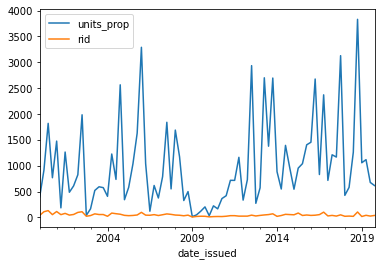

In [ ]:
sfbb = sfb_full.copy()
date_col = 'date_issued'
period = 'Q'
sfbb[date_col] = sfbb[date_col].dt.to_period(period)
sfbb = sfbb.groupby(date_col).agg({
    'units_prop':'sum', 
    'rid':'count'
    })
sfbb.plot()

#sfb_full.groupby(focus_col).agg({
#    'units_prop':'sum', 'rid':'count'
#})['rid'].plot.bar()

In [50]:
def plot_labels(focus_gdf, label_col, ax, zorder=8):
    xylabel = zip(focus_gdf.geometry.centroid.x, focus_gdf.geometry.centroid.y, focus_gdf[label_col])
    for x, y, label in xylabel:
        ax.annotate(
            label, xy=(x, y), 
            fontsize='large',
            fontweight='bold',
            zorder=zorder
            )
def plot_quads(ax, zorder=8):
    plot_labels(sfquad, 'quad', ax, zorder=zorder)

def get_cmap(data_list, cmap, grey_bottom=True, skip_1=False):
    def get_colors(n, cmap):
        from mycolorpy import colorlist as mcp
        color1=mcp.gen_color(cmap=cmap,n=n)
        return color1
    reduce = 0
    if grey_bottom == True:
        light_grey = '#D3D3D3'
        reduce = -1
    if skip_1 == True:
        reduce = 1
    cmap = get_colors(len(data_labels)+reduce, cmap)
    if grey_bottom == True:
        cmap = [light_grey] + cmap
    if skip_1 == True:
        cmap = cmap[1:]
    return {v:c for v,c  in zip(data_labels, cmap)}

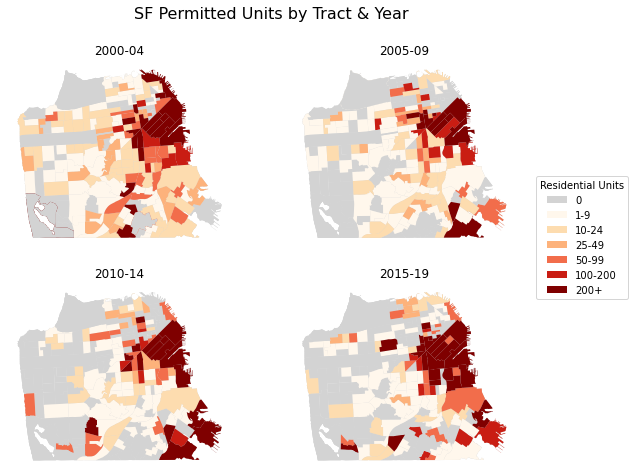

In [ ]:
import matplotlib.pyplot as plt

nrows, ncols = (2,2)
fig, axes = plt.subplots(nrows,ncols)

date_col = '5years'
sfbb = sfb_full.groupby(['geoid10', date_col]).agg({
    'units_prop':'sum', 'rid':'count'
    }).reset_index(drop=False)
sfbb = sfblock.set_index('geoid10').join(sfbb.set_index('geoid10'))

focus_col = 'unit_bins'
date_col = '5years'

def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(sfbb[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='units_prop'
data_bins = [0,1,10,25,50,100,200,max(sfbb[focus_col])]
data_labels = ['0','1-9','10-24','25-49', '50-99', '100-200', '200+']
sfbb['unit_bins'] = get_bins(sfbb, focus_col, data_bins, data_labels)

cmap = get_cmap(data_labels, 'OrRd')

focus_col = 'unit_bins'

year_bins = list(sfb_full[date_col].unique())
year_bins.sort()
year_bins = np.array(year_bins).reshape(nrows, ncols)

for row in range(nrows):
    for col in range(ncols):
        year = year_bins[row,col]
        ax = axes[row,col]
        sfbb_sub = sfbb[
            (sfbb[date_col]==year)&(sfbb[focus_col]!=0)
        ]
        for value,color in cmap.items():
            sfbb_sub[sfbb_sub[focus_col]==value].plot(
                ax=ax,
                zorder=5, legend=True,
                color = color
            )
        sfblock.plot(
            ax=ax, zorder=4,
            color='lightgrey'
            )
        #plot_quads(ax)
        sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

        ax.set_title('20'+str(year))
        ax.set_axis_off()

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
fig.legend(handles = handles, labels=labels,
       loc="center right", 
       title="Residential Units"
       #borderaxespad=0.1
       )
plt.subplots_adjust(right=0.85)

fig.suptitle('SF Permitted Units by Tract & Year', fontsize=16)
fig.set_size_inches(10, 7.5, forward=True)
#fig.tight_layout()

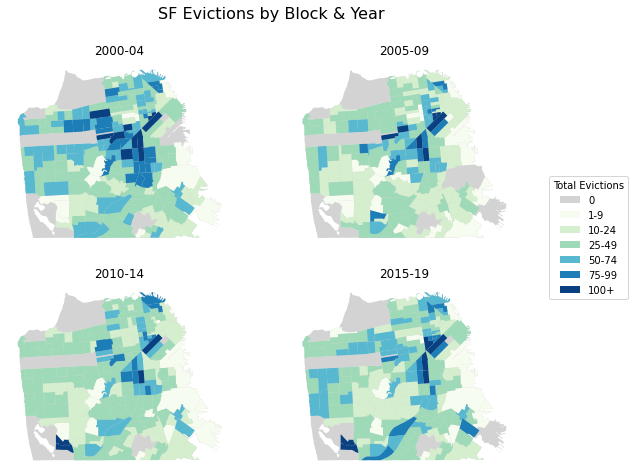

In [132]:
import matplotlib.pyplot as plt

nrows, ncols = (2,2)
fig, axes = plt.subplots(nrows,ncols)

date_col = '5years'
sfbb = sfevict.join(sfblock.set_index(['block_id', 'geoid10'])).reset_index()
sfbb = gpd.GeoDataFrame(sfbb)

focus_col = 'unit_bins'
date_col = '5years'

def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='tot_evictions'
data_bins = [0,1,10,25,50,75,100,max(sfbb[focus_col])]
data_labels = ['0','1-9','10-24','25-49', '50-74', '75-99', '100+']
sfbb['tot_evictions'] = get_bins(sfbb, focus_col, data_bins, data_labels)

cmap = get_cmap(data_labels, 'GnBu')

focus_col = 'tot_evictions'

year_bins = list(sfb_full[date_col].unique())
year_bins.sort()
year_bins = np.array(year_bins).reshape(nrows, ncols)

for row in range(nrows):
    for col in range(ncols):
        year = year_bins[row,col]
        ax = axes[row,col]
        sfbb_sub = sfbb[
            (sfbb[date_col]==year)#&(sfbb[focus_col]!=0)
        ]
        for value,color in cmap.items():
            sfbb_sub[sfbb_sub[focus_col]==value].plot(
                ax=ax,
                zorder=5,
                color = color
            )
        sfblock.plot(
            ax=ax, zorder=4,
            color='lightgrey'
            )
        #plot_quads(ax)

        ax.set_title('20'+str(year))
        ax.set_axis_off()

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
fig.legend(handles = handles, labels=labels,
       loc="center right", 
       title="Total Evictions"
       #borderaxespad=0.1
       )
plt.subplots_adjust(right=0.85)

fig.suptitle('SF Evictions by Block & Year', fontsize=16)
fig.set_size_inches(10, 7.5, forward=True)
#fig.tight_layout()

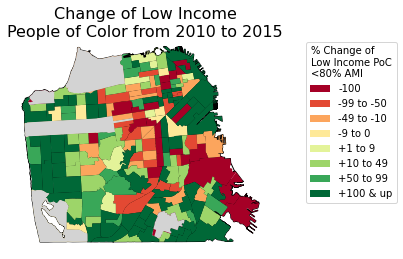

In [ ]:
def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='poc_linc.pct.10_15'
data_bins = [min(sfdemo[focus_col]), -100, -50, -10, 0, 10, 50, 100, max(sfdemo[focus_col])]
data_labels = ['-100','-99 to -50','-49 to -10', '-9 to 0', '+1 to 9', '+10 to 49', '+50 to 99', '+100 & up']
sfdemo['binned'] = get_bins(sfdemo, focus_col, data_bins, data_labels)
focus_col = 'binned'

def get_cmap(data_list, cmap, grey_bottom=True):
    def get_colors(n, cmap):
        from mycolorpy import colorlist as mcp
        color1=mcp.gen_color(cmap=cmap,n=n)
        return color1
    reduce = 0
    if grey_bottom == True:
        light_grey = '#D3D3D3'
        reduce += 1
    cmap = get_colors(len(data_labels)-reduce, cmap)
    if grey_bottom == True:
        cmap = [light_grey] + cmap
    return {v:c for v,c  in zip(data_labels, cmap)}
cmap = get_cmap(data_labels, 'RdYlGn', grey_bottom=False)

ax = sfblock.plot(zorder=4, color='None')

for value,color in cmap.items():
    sfdemo[sfdemo[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       title="% Change of\nLow Income PoC\n<80% AMI",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('Change of Low Income\nPeople of Color from 2010 to 2015', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

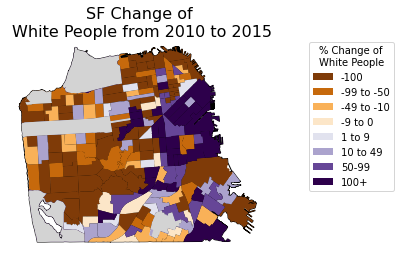

In [ ]:
def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='wht.pct.10_15'
data_bins = [min(sfdemo[focus_col]), -100, -50, -10, 0, 10, 50, 100, max(sfdemo[focus_col])]
data_labels = ['-100','-99 to -50','-49 to -10', '-9 to 0', '1 to 9', '10 to 49', '50-99', '100+']
sfdemo['binned'] = get_bins(sfdemo, focus_col, data_bins, data_labels)
focus_col = 'binned'
sfdemo = gpd.overlay(sfdemo, sf_landform, how='intersection')

def get_cmap(data_list, cmap, grey_bottom=True):
    def get_colors(n, cmap):
        from mycolorpy import colorlist as mcp
        color1=mcp.gen_color(cmap=cmap,n=n)
        return color1
    reduce = 0
    if grey_bottom == True:
        light_grey = '#D3D3D3'
        reduce += 1
    cmap = get_colors(len(data_labels)-reduce, cmap)
    if grey_bottom == True:
        cmap = [light_grey] + cmap
    return {v:c for v,c  in zip(data_labels, cmap)}
cmap = get_cmap(data_labels, 'PuOr', grey_bottom=False)

ax = sftract.plot(zorder=4, color='None')

for value,color in cmap.items():
    sfdemo[sfdemo[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       #loc="center right", 
       title="% Change of\nWhite People",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('SF Change of \nWhite People from 2010 to 2015', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

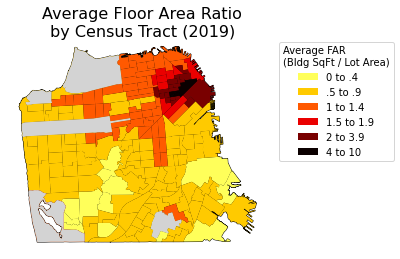

In [54]:
def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_gdf = gpd.GeoDataFrame(sfpar_g.join(sftract.set_index('geoid10')))

focus_col='FAR.avg.2019'
data_bins = [0, .5, 1, 1.5, 2, 4, max(focus_gdf[focus_col])]
data_labels = ['0 to .4', '.5 to .9', '1 to 1.4', '1.5 to 1.9', '2 to 3.9', '4 to 10']
focus_gdf['binned'] = get_bins(focus_gdf, focus_col, data_bins, data_labels)
focus_col = 'binned'
focus_gdf = gpd.overlay(focus_gdf, sf_landform, how='intersection')


cmap = get_cmap(data_labels, 'hot_r', grey_bottom=False, skip_1=True)

ax = sftract.plot(zorder=4, color='None')

for value,color in cmap.items():
    focus_gdf[focus_gdf[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       #loc="center right", 
       title="Average FAR\n(Bldg SqFt / Lot Area)",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('Average Floor Area Ratio\nby Census Tract (2019)', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

<AxesSubplot:>

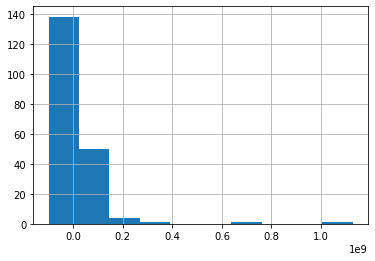

In [71]:
sfdis['occ_ch.00_18'] = sfdis['occ_own_ch.pct.00_18'].astype(float) * 100
sfdis['occ_ch.00_18'].hist()

In [ ]:
max(focus_gdf[focus_col])

<AxesSubplot:>

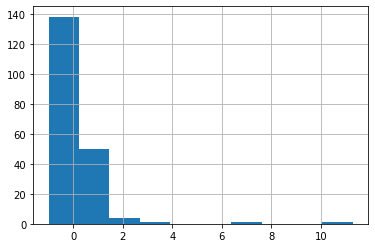

In [85]:
focus_col= 'occ_own_ch.pct.00_18'
sfdis[
    (sfdis[focus_col]<1000)&(sfdis[focus_col]>-1000)
]['occ_own_ch.pct.00_18'].hist()

In [95]:
focus_col='occ_own_ch.pct.00_18'
min(focus_gdf[focus_col]*100)

-100.0

In [107]:
sfdis[focus_col]

geoid10
06075015600   -8.951224e+18
06075010200    2.419670e+19
06075010800    6.291356e+18
06075033100   -6.779661e+18
06075040200    5.220704e+19
                   ...     
06075980200    4.982456e+19
06075980300   -1.000000e+20
06075980501   -7.332231e+19
06075980600   -7.880952e+18
06075980900   -7.384684e+19
Name: occ_own_ch.pct.00_18, Length: 195, dtype: float64

In [111]:
def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_gdf = sfdis.copy()
focus_col='occ_own_ch.pct.00_18'
focus_gdf[focus_col] = focus_gdf[focus_col] * 100
#sfdis = sfdis[
#    (sfdis[focus_col]<1000)&(sfdis[focus_col]>-1000)
#]

data_bins = [min(focus_gdf[focus_col]), -50, -10, 10, 50, max(focus_gdf[focus_col])]
data_labels = ['+50%','49 to 10%', '9 to -9%', '-10 to -49%', '-50%']
focus_gdf['binned'] = get_bins(focus_gdf, focus_col, data_bins, data_labels)
focus_col = 'binned'
focus_gdf = gpd.overlay(focus_gdf, sf_landform, how='intersection')


cmap = get_cmap(data_labels, 'seismic_r', grey_bottom=False)

ax = sftract.plot(zorder=4, color='None')

for value,color in cmap.items():
    focus_gdf[focus_gdf[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       #loc="center right", 
       title="Change of Units\nthat are occupied\nby a renter",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('Change in Renter Occupied Units\n2010-18', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

1128.972043010753

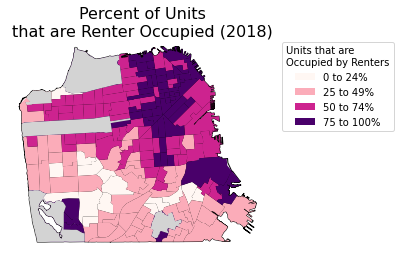

In [131]:


def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_gdf = sfdis.copy()
focus_col='occ_rent.pct.18'
#focus_gdf[focus_col] = focus_gdf[focus_col] * 100
#sfdis = sfdis[
#    (sfdis[focus_col]<1000)&(sfdis[focus_col]>-1000)
#]

data_bins = [0, 25, 50, 75, 100]
data_labels = ['0 to 24%', '25 to 49%', '50 to 74%', '75 to 100%']
focus_gdf['binned'] = get_bins(focus_gdf, focus_col, data_bins, data_labels)
focus_col = 'binned'
focus_gdf = gpd.overlay(focus_gdf, sf_landform, how='intersection')


cmap = get_cmap(data_labels, 'RdPu', grey_bottom=False)

ax = sftract.plot(zorder=4, color='None')

for value,color in cmap.items():
    focus_gdf[focus_gdf[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       #loc="center right", 
       title="Units that are\nOccupied by Renters",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('Percent of Units\nthat are Renter Occupied (2018)', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

In [ ]:
import seaborn

date_col = 'date_status'

sfb_plot = sfb[[date_col, 'units_prop', 'status', 'pid']]
sfb_plot[date_col] = sfb_plot[date_col].dt.to_period("Y").astype(str)

sfb_plot = sfb_plot.groupby([
    date_col, 'status'
    ]).agg({'units_prop':'sum', 'pid':'count'}).reset_index(drop=False)

seaborn.relplot(
    data=sfb_plot, 
    x=date_col, y='pid', hue='status', 
    aspect=1.61, kind="line"
    )


In [ ]:
approved_status = [
    'complete', 'issued',
    'filing', 'filed', 'disapproved', 'reinstated', 'appeal',
    'approved'
]

sfb.loc[sfb['status'].isin(approved_status)].plot()

## Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

date_open = '2014Q3'
date_close = '2015Q3'

fig  = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

def date_group(date_col, period = 'Q', group_df = sfp_all):
    return group_df.sort_values(date_col).groupby(group_df[date_col].dt.to_period(period))['id'].count()

date_col = 'date_open'
open_df = date_group(date_col)
open_df.plot(ax=ax, kind="line", label='Permits Opened')
#date_group(date_col, period="Y").plot(ax=ax, color='black', kind="bar")

date_col = 'date_close'
close_df = date_group(date_col)
close_df.plot(ax=ax, color='red', kind="line", label='Permits Closed')

ax.set_xlim(['2013Q3',None])
ax.set_ylim([0,None])

col = 'darkblue'
ax.vlines(
    x=date_open, ymin=0, ymax=max(open_df), colors=col, ls=':',
    label = 'Open Date Cutoff')
#ax.hlines(y=max(open_df), xmin=date_open, xmax=max(open_df.index), colors=col, ls=':')

col = 'maroon'
ax.vlines(
    x=date_close, ymin=0, ymax=max(close_df), colors=col, ls=':',
    label = 'Close Date Cutoff'
    )
#ax.hlines(y=max(close_df), xmin=date_close, xmax=max(close_df.index), colors=col, ls=':')

ax.set_xlabel('Quarters')
ax.set_ylabel('Count of Permits')
ax.legend(loc='best')

plt.show()

In [ ]:
#sfp[sfp['date_open']>='2015-01-01'].count()
#sfp[sfp['date_open']<'2015-01-01'].count()

sfp['date_openclose'] = sfp['date_open'].astype(str) + sfp['date_close'].astype(str)

sfp['length'] = (sfp['date_close'] - sfp['date_open']).dt.days
#(sfp['length']/365).hist()

long_plot = sfp.dropna(subset=['date_open','date_close'])

#fig  = plt.figure(figsize = (8,6))
#ax = fig.add_subplot(111)

period = 'Q'
#ax.barh(
#    long_plot.date_open.dt.to_period(period), 
#    long_plot.date_close.dt.to_period(period), 
#    left=long_plot.date_open.dt.to_period(period))


In [ ]:
a = sfp['date_app_acc'].dropna().count()
t = len(sfp)

a/t

unit_max = 100000
sjp_join = sfp[sfp['#units_prop']<unit_max].copy()

sfp_nhood = sjp_join.groupby('nhood')['id'].count().to_dict()
sfnhood['permit_count'] = sfnhood['nhood'].map(sfp_nhood).fillna(value=0).astype(int)


sfp_unit = sjp_join.groupby('nhood')['#units_prop'].sum().to_dict()
sfnhood['unit_prop_count'] = sfnhood['nhood'].map(sfp_unit).fillna(value=0)

sjp_join['unit_per_permit'] = sjp_join['#units_prop']/1
sfp_upp = sjp_join.groupby('nhood')['unit_per_permit'].median().to_dict()
sfnhood['unit_per_permit'] = sfnhood['nhood'].map(sfp_upp).fillna(value=0)

In [ ]:
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase

class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})

def set_label(
    bins,
    zero = True,
    binder = '-'
    ):
    binder = ' {} '.format(binder)

    if zero == True:
        bins = [0] + bins

    bins = list(zip(bins[:-1],bins[1:]))

    def to_string(pair):
        paired = str(pair[0]) + binder + str(pair[1])
        return paired

    bins = [to_string(bin) for bin in bins]
    bins = [
        '0' if bin == '0' + binder + '0'
        else bin 
        for bin in bins
        ]
    return bins

def set_legend(leg, new_texts, location=2):
    
    leg._loc = location

    for lbl,new_text in zip(leg.get_texts(), new_texts):
        label_text = lbl.get_text()
        #lower = label_text.split()[0]
        #upper = label_text.split()[2]
        #new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
        lbl.set_text(new_text)

In [ ]:
plot_col = 'permit_count'

map_bin = dict(bins=[0,50,100,200,300,400, sfnhood[plot_col].max()])

ax = sfnhood.plot(
    column=plot_col, 
    cmap='YlGn', 
    figsize=(40, 10), 
    scheme='User_Defined',
    classification_kwds=map_bin, k=len(map_bin)-1, 
    legend=True, linewidth=0.75, edgecolor='grey')

sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)
for x, y, label in sfquads:
    ax.annotate(
        label, xy=(x, y), xytext=(3, 3), 
        textcoords="offset points",
        fontsize='large',
        fontweight='bold'
        )

leg = ax.get_legend()
set_legend(leg, set_label(map_bin['bins']))

,shape_area,objectid_1,objectid,globalid,quad,id,shape_len,geometry
0,362268282.883,4,641,{F27C8EDD-E046-4CD1-9071-8159E6102624},SE,0,227055.35836,"MULTIPOLYGON (((172787.480 91144.234, 172882.1..."
1,89271860.5954,3,642,{B4EECB96-F331-4B1B-99BC-E2AB05E2B09B},NE,0,99030.8515062,"MULTIPOLYGON (((166171.388 101163.671, 166226...."
2,338207863.134,1,643,{1B40529A-8F68-472A-9DB0-7C07C9C8DE0A},NW,0,116095.118353,"MULTIPOLYGON (((149466.332 100933.563, 149486...."
3,498989359.983,2,644,{7C611B7F-5452-4456-9100-60B437F86B72},SW,0,114854.453545,"MULTIPOLYGON (((164827.702 85927.360, 164846.9..."


In [ ]:
from matplotlib.text import Text
from matplotlib.legend import Legend

handles = list(string.ascii_uppercase)[:N] 
labels = [f"Model Name {c}" for c in handles]

fig, ax = plt.subplots()
ax.scatter(x, y, s=100, c=colors, alpha=0.5)
for i, xy in enumerate(zip(x, y)):
    ax.annotate(handles[i], xy=xy)

ax.legend(handles=handles, labels=labels)

In [ ]:
sfp.sort_values('#units_prop', ascending=False).head(30)

In [ ]:
path = r'static_data\sf_permit_acronyms.xlsx'
sfp_acr = pd.read_excel(path)
sfp_acr = {
    acr:name for acr,name in sfp_acr.set_index('Acronym')['Name'].to_dict().items()
    if type(acr) == str
}